In [1]:
import sys
sys.path.append(r'..')
from data import DecisionTreeData, LogisticRegressionData

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = DecisionTreeData(r'..\..\breast+cancer+wisconsin+diagnostic\wdbc.data')
X = data.get_X()
y = data.get_y()
X = data.normalize_data(X)
X = np.hstack((np.ones((X.shape[0], 1)), X))
X_train, X_test, y_train, y_test = data.split_data(X, y, test_size=0.2)

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 31), (114, 31), (455,), (114,))

Find the best depth

In [4]:
depths = [depth for depth in range(1, 21)]
scores = {}
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    score = dt.score(X_test, y_test)
    scores[depth] = score

best_depth = max(scores, key=scores.get)
best_dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

Visualize the best tree

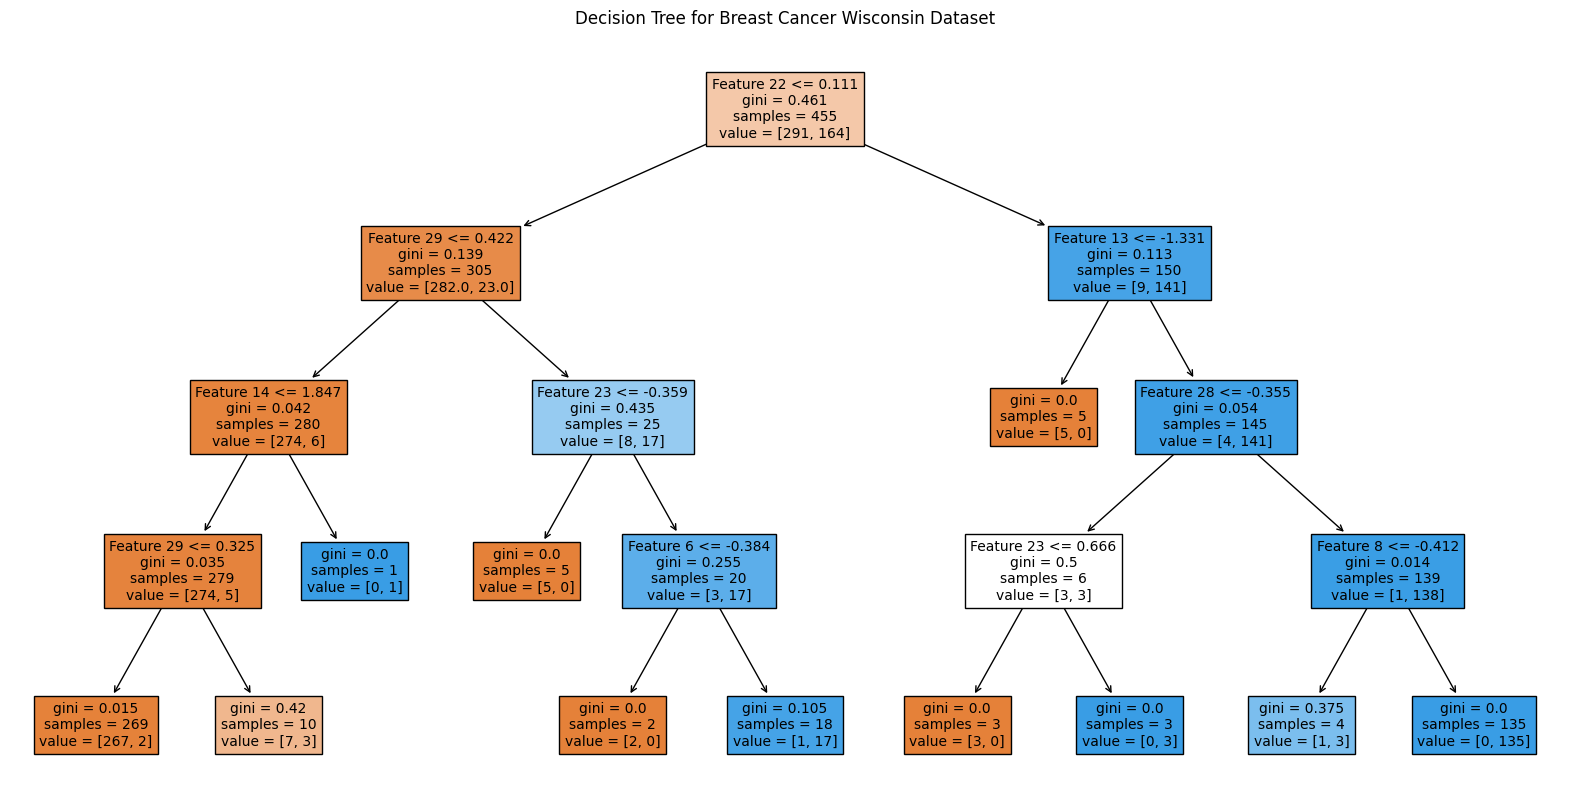

({1: 0.8947368421052632,
  2: 0.9122807017543859,
  3: 0.9035087719298246,
  4: 0.9210526315789473,
  5: 0.9122807017543859,
  6: 0.9122807017543859,
  7: 0.8947368421052632,
  8: 0.8947368421052632,
  9: 0.8947368421052632,
  10: 0.8947368421052632,
  11: 0.8947368421052632,
  12: 0.8947368421052632,
  13: 0.8947368421052632,
  14: 0.8947368421052632,
  15: 0.8947368421052632,
  16: 0.8947368421052632,
  17: 0.8947368421052632,
  18: 0.8947368421052632,
  19: 0.8947368421052632,
  20: 0.8947368421052632},
 4)

In [5]:
plt.figure(figsize=(20,10))
tree_plot = plot_tree(
    decision_tree=best_dt,
    filled=True,
    feature_names=[f'Feature {i}' for i in range(1, X_train.shape[1] + 1)],
    fontsize=10
)
plt.title('Decision Tree for Breast Cancer Wisconsin Dataset')
plt.show()

scores, best_depth

In [12]:
from sklearn.metrics import accuracy_score

# Predicting the labels for the test set
y_pred = best_dt.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Displaying the accuracy
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9211


Get best features, Compare with Linear Model

In [6]:
feature_importances = best_dt.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

# the most significant 5, 10, 15, and 20 features based on their importance scores
top_5_features = sorted_indices[:5]
top_10_features = sorted_indices[:10]
top_15_features = sorted_indices[:15]
top_20_features = sorted_indices[:20]
top_30_features = sorted_indices[:30]

top_5_features, top_10_features, top_15_features, top_20_features, top_30_features

(array([21, 28, 12, 22,  5], dtype=int64),
 array([21, 28, 12, 22,  5, 27, 13,  7,  4,  3], dtype=int64),
 array([21, 28, 12, 22,  5, 27, 13,  7,  4,  3,  2,  1,  6,  8,  9],
       dtype=int64),
 array([21, 28, 12, 22,  5, 27, 13,  7,  4,  3,  2,  1,  6,  8,  9, 10, 11,
        30, 15, 14], dtype=int64),
 array([21, 28, 12, 22,  5, 27, 13,  7,  4,  3,  2,  1,  6,  8,  9, 10, 11,
        30, 15, 14, 29, 16, 17, 18, 19, 20, 23, 24, 25, 26], dtype=int64))

In [7]:
data = LogisticRegressionData(r'..\..\breast+cancer+wisconsin+diagnostic\wdbc.data')
X = data.get_X()
y = data.get_y()
X = data.normalize_data(X)
X = np.hstack((np.ones((X.shape[0], 1)), X))
X_train_lin, X_test_lin, y_train_lin, y_test_lin = data.split_data(X, y, test_size=0.2)

In [8]:
from GD import init_w, loss, g, l2, l2_g, predict

feature_sets = [top_5_features, top_10_features, top_15_features, top_20_features]
feature_accuracies = []
feature_losses = []

learning_rate = 0.01
epochs =  1000
_lambda = 0.1

for features, f in zip(feature_sets, [5,10,15,20]):
    X_train_subset = X_train_lin[:, features]
    # X_train_subset = np.hstack((np.ones((X_train_subset.shape[0], 1)), X_train_subset))
    X_test_subset = X_test_lin[:, features]
    # X_test_subset = np.hstack((np.ones((X_test_subset.shape[0], 1)), X_test_subset))
    
    n = X_train_subset.shape[1]
    w = init_w(n)
    
    current_loss = loss(X_train_subset, y_train_lin, w) + l2(w, _lambda)
    # print(f"Before training Loss: {current_loss}")

    predictions = predict(X_test_subset, w)
    accuracy = np.mean(predictions == y_test)
    # print(f"Before training Accuracy: {accuracy * 100:.4f}%")
    # print()

    loss_values = [current_loss]
    accuracy_values = [accuracy]

    for epoch in range(1, epochs+1):
        gradient = g(X_train_subset, y_train_lin, w) + l2_g(w, _lambda)
        w -= learning_rate * gradient

        current_loss = loss(X_train_subset, y_train_lin, w) + l2(w, _lambda)
        loss_values.append(current_loss)
        # print(f"Epoch {epoch}, Loss: {current_loss}")
        
        predictions = predict(X_test_subset, w)
        accuracy = np.mean(predictions == y_test_lin)
        accuracy_values.append(accuracy)
        if epoch % 500 == 0:
            print(f"Feature Set: {f}, Accuracy: {accuracy * 100:.4f}%")
        # print(f"Accuracy: {accuracy * 100:.4f}%")
        # print()
    
    feature_accuracies.append(accuracy_values.copy())
    feature_losses.append(loss_values.copy())
    

Feature Set: 5, Accuracy: 96.4912%
Feature Set: 5, Accuracy: 97.3684%
Feature Set: 10, Accuracy: 97.3684%
Feature Set: 10, Accuracy: 97.3684%
Feature Set: 15, Accuracy: 96.4912%
Feature Set: 15, Accuracy: 97.3684%
Feature Set: 20, Accuracy: 96.4912%
Feature Set: 20, Accuracy: 97.3684%


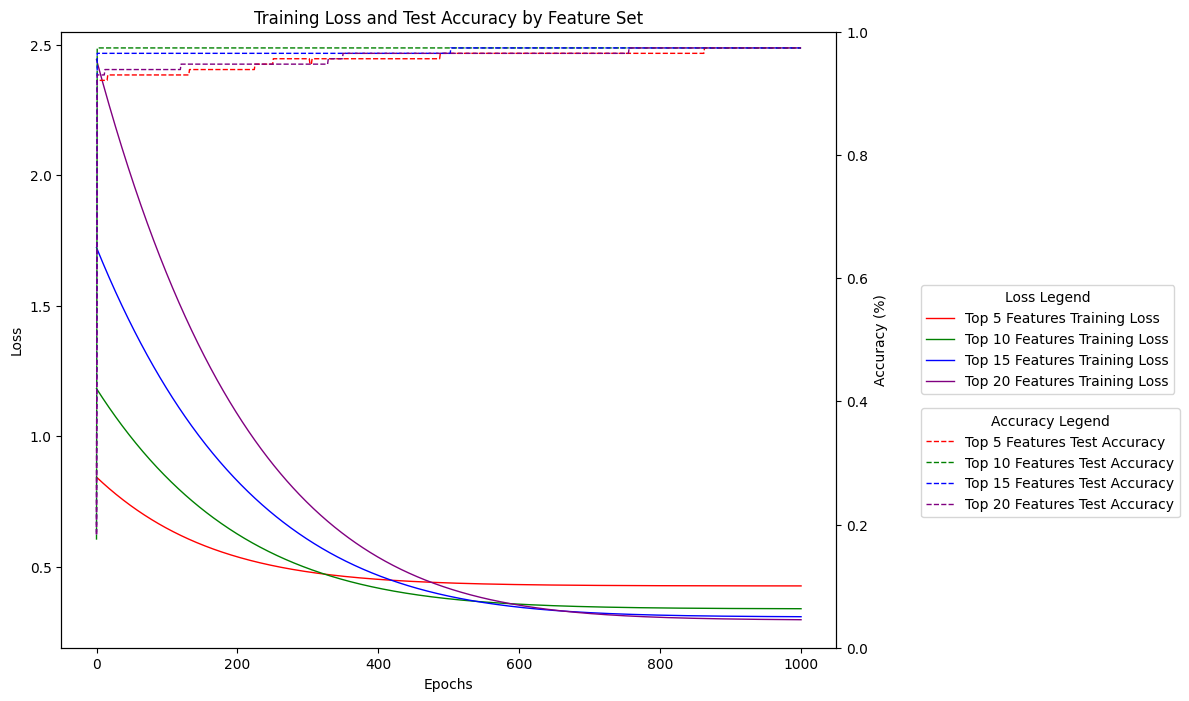

In [9]:
# Plot settings
epochs = 1000
colors = ['red', 'green', 'blue', 'purple']
feature_sets = ['Top 5 Features', 'Top 10 Features', 'Top 15 Features', 'Top 20 Features']

# Create a figure
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot each feature set's data
for idx, (loss_values, accuracy_values) in enumerate(zip(feature_losses, feature_accuracies)):
    ax1.plot(range(epochs + 1), loss_values, label=f'{feature_sets[idx]} Training Loss', color=colors[idx], linewidth=1)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')

# Create secondary axis for accuracy
ax2 = ax1.twinx()

for idx, accuracy_values in enumerate(feature_accuracies):
    ax2.plot(range(epochs + 1), accuracy_values, label=f'{feature_sets[idx]} Test Accuracy', linestyle='--', color=colors[idx], linewidth=1)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='y')

# Improve the legend
ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), title="Loss Legend")
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.3), title="Accuracy Legend")

plt.title('Training Loss and Test Accuracy by Feature Set')
plt.show()

Random forest

In [10]:
num_trees = [1, 2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 100, 128, 150, 200]
train_scores_rf = []
test_scores_rf = []
train_scores_dt = best_dt.score(X_train, y_train)
test_scores_dt = best_dt.score(X_test, y_test)

for n in num_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    train_scores_rf.append(rf.score(X_train, y_train))
    test_scores_rf.append(rf.score(X_test, y_test))


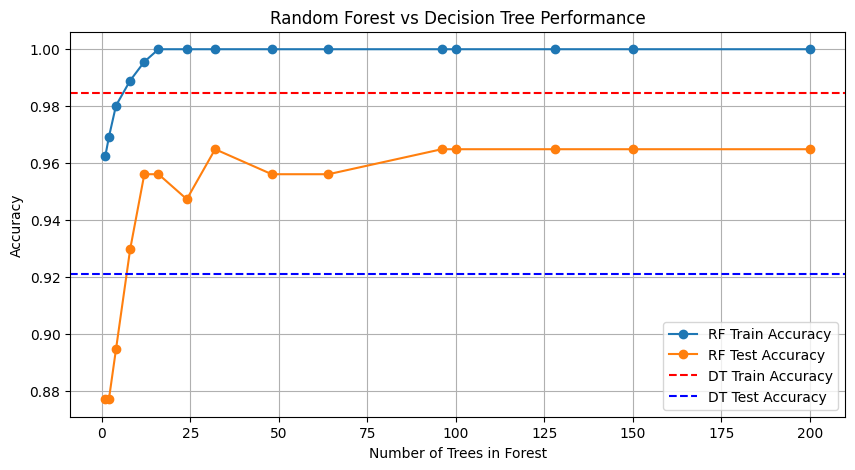

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(num_trees, train_scores_rf, label='RF Train Accuracy', marker='o')
plt.plot(num_trees, test_scores_rf, label='RF Test Accuracy', marker='o')
plt.axhline(y=train_scores_dt, color='r', linestyle='--', label='DT Train Accuracy')
plt.axhline(y=test_scores_dt, color='b', linestyle='--', label='DT Test Accuracy')
plt.xlabel('Number of Trees in Forest')
plt.ylabel('Accuracy')
plt.title('Random Forest vs Decision Tree Performance')
plt.legend()
plt.grid(True)
plt.show()